In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/test.zip', 'r') as zipObj:
       zipObj.extractall('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/test')

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/train.zip', 'r') as zipObj:
       zipObj.extractall('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/train')

In [ ]:
train_dir = '/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/train/train'
val_dir = '/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/test/test'

In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
len(train_dataloader), len(train_dataset)

(1601, 12807)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


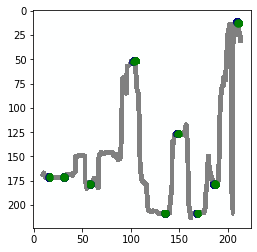

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

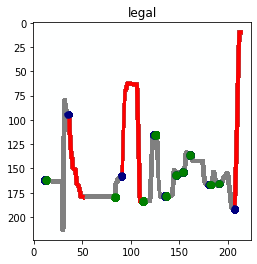

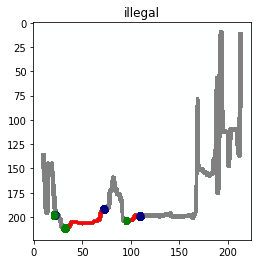

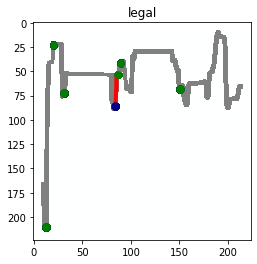

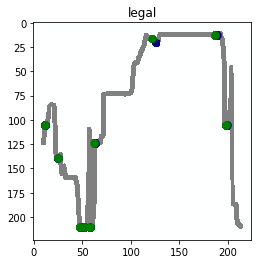

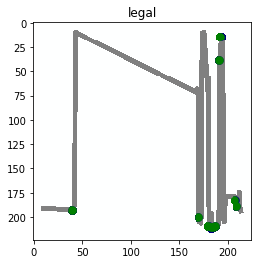

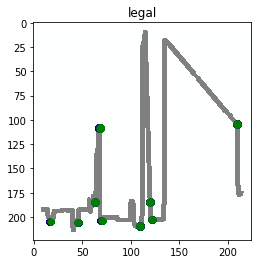

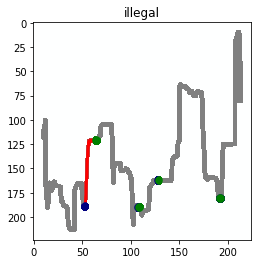

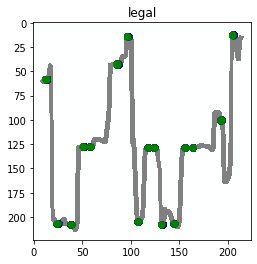

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

class_names = ['legal', 'illegal']
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.7MB/s]


In [ ]:
from tqdm import tqdm
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 1601/1601 [01:13<00:00, 21.82it/s]

train Loss: 0.4016 Acc: 0.8245



100%|██████████| 376/376 [00:16<00:00, 23.30it/s]

val Loss: 0.4446 Acc: 0.7986
Epoch 1/9:



100%|██████████| 1601/1601 [01:13<00:00, 21.70it/s]

train Loss: 0.3894 Acc: 0.8335



100%|██████████| 376/376 [00:16<00:00, 22.94it/s]

val Loss: 0.4740 Acc: 0.7933
Epoch 2/9:



100%|██████████| 1601/1601 [01:14<00:00, 24.33it/s]

train Loss: 0.3813 Acc: 0.8360



100%|██████████| 376/376 [00:16<00:00, 22.86it/s]

val Loss: 0.4884 Acc: 0.7930
Epoch 3/9:



100%|██████████| 1601/1601 [01:14<00:00, 25.13it/s]

train Loss: 0.3814 Acc: 0.8375



100%|██████████| 376/376 [00:16<00:00, 23.19it/s]

val Loss: 0.4350 Acc: 0.8038
Epoch 4/9:



100%|██████████| 1601/1601 [01:11<00:00, 25.93it/s]

train Loss: 0.3797 Acc: 0.8392



100%|██████████| 376/376 [00:16<00:00, 23.08it/s]

val Loss: 0.4462 Acc: 0.8013
Epoch 5/9:



100%|██████████| 1601/1601 [01:11<00:00, 25.82it/s]

train Loss: 0.3781 Acc: 0.8391



100%|██████████| 376/376 [00:16<00:00, 22.83it/s]

val Loss: 0.4343 Acc: 0.8015
Epoch 6/9:



100%|██████████| 1601/1601 [01:11<00:00, 22.32it/s]

train Loss: 0.3523 Acc: 0.8487



100%|██████████| 376/376 [00:16<00:00, 22.94it/s]

val Loss: 0.4262 Acc: 0.8061
Epoch 7/9:



100%|██████████| 1601/1601 [01:12<00:00, 21.96it/s]

train Loss: 0.3557 Acc: 0.8514



100%|██████████| 376/376 [00:16<00:00, 22.77it/s]

val Loss: 0.4286 Acc: 0.8061
Epoch 8/9:



100%|██████████| 1601/1601 [01:11<00:00, 22.24it/s]

train Loss: 0.3497 Acc: 0.8488



100%|██████████| 376/376 [00:16<00:00, 22.28it/s]

val Loss: 0.4272 Acc: 0.8041
Epoch 9/9:



100%|██████████| 1601/1601 [01:12<00:00, 25.40it/s]

train Loss: 0.3528 Acc: 0.8469



100%|██████████| 376/376 [00:16<00:00, 23.41it/s]

val Loss: 0.4335 Acc: 0.8005


In [ ]:
test_dir = '/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/test/test'
#shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 376/376 [00:16<00:00, 22.93it/s]


In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

#for img, pred in zip(inputs, test_predictions):
#    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
#submission_df['label'] = submission_df['label'].map(lambda pred: 'legal' if pred > 0.01 else 'illegal')
submission_df['id'] = submission_df['id'].str.replace('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/test/test/', '')
submission_df['id'] = submission_df['id'].str.replace('.png', '')
submission_df.set_index('id', inplace=True)

In [ ]:
submission_df

,label
id,
illegal/session_0126772600-x0,0.282513
illegal/session_0126772600-x1,0.056180
illegal/session_0126772600-x2,0.006265
illegal/session_0126772600-x3,0.033991
illegal/session_0126772600-x4,0.126609
...,...
legal/session_9932324920-y6,0.063231
legal/session_9932324920-y7,0.562928
legal/session_9932324920-y8,0.040318


In [ ]:
submission_df.to_csv('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/submission12.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mouse_dynamics/user12/submission12.csv')
#df = df.drop(columns=['Unnamed: 0'])

In [ ]:
TP = df.loc[(df['id'].str[0:3] == 'ill') & (df['label']<0.5)].count().to_list()[0]
FP = df.loc[(df['id'].str[0:3] == 'leg') & (df['label']<0.5)].count().to_list()[0]
FN = df.loc[(df['id'].str[0:3] == 'ill') & (df['label']>0.5)].count().to_list()[0]
TN = df.loc[(df['id'].str[0:3] == 'leg') & (df['label']>0.5)].count().to_list()[0]

In [ ]:
print(TP, FP, FN, TN)
print(TP/(TP+FP), TP/(TP+FN))

2178 470 129 228
0.8225075528700906 0.9440832249674902


0.809819497902857


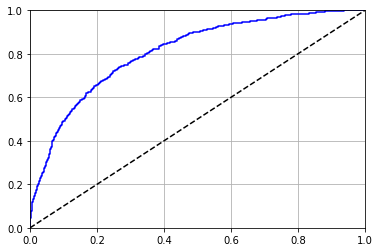

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

y = np.array(df['id'].str[0:3] == 'leg')
x = np.array(df['label'])
fpr, tpr, thresholds = roc_curve(y,x,pos_label=True)
roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.plot(fpr, tpr, 'b')
plt.plot([0,1], [0,1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.show()

In [ ]:


import joblib

In [ ]:
filename = 'mouse_model_pickled.pkl'
joblib.dump(model, filename)

In [ ]:
pwd

'/content/Mouse-Dynamics-Challenge/test_files'

In [ ]:
!git clone https://github.com/balabit/Mouse-Dynamics-Challenge.git

Cloning into 'Mouse-Dynamics-Challenge'...
remote: Enumerating objects: 1711, done.
remote: Total 1711 (delta 0), reused 0 (delta 0), pack-reused 1711
Receiving objects: 100% (1711/1711), 42.60 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (1678/1678), done.


In [ ]:
cd ..

/


In [ ]:
import pandas as pd
import math
import os

os.chdir("../../../Mouse-Dynamics-Challenge/test_files/user15/")
listing = os.listdir('../../../Mouse-Dynamics-Challenge/test_files/user15/') 

#calculate distance between two points
def distance(x1,y1,x2,y2):
    return((pow(x2-x1,2)+pow(y2-y1,2))**(1.0/2))

#returns cps, avg. click time & no. of clicks
def clicks(df,data): 
    clicknum=0.01 #no. of clicks 
    avgclicktime=0; #average click time
    clickpersec=0; #clicks per sec

    for i in range(0, len(df)-1):
        if(df.iloc[i]['state']=='Pressed'):
            clicknum= clicknum+1
            if (df.iloc[i+1]['state']=='Released'):
                avgclicktime= avgclicktime+(df.iloc[i+1]['client timestamp'])-(df.iloc[i]['client timestamp'])
    avgclicktime=avgclicktime/clicknum
    clickpersec=clicknum/((df.iloc[len(df)-1]['client timestamp']-df.iloc[0]['client timestamp'])+0.01)
    data.append(clickpersec)
    data.append(avgclicktime)
    data.append(clicknum)

#calculate average speed of mouse
def speed(df,data):
    spsum=0 #average speed
    for i in range(0, len(df)-2):
        d=distance(df.iloc[i+1]['x'],df.iloc[i+1]['y'],df.iloc[i]['x'],df.iloc[i]['y'])
        t=(df.iloc[i+1]['client timestamp'])-(df.iloc[i]['client timestamp'])
        if (t!=0):
            spsum=spsum+(d/(t+0.01))
    spsum= spsum/((len(df)-2)+0.01)
    data.append(spsum)

#calculate avg. drag length, avg. drag speed, no. of drags & avg. drag time
def drag(df,data):
    draglen=0 #avg. drag length
    dragspeed=0 #avg. drag speed
    dragnum=0.01 #no. of drags
    dragtime=0 #avg. drag time
    for i in range(0,len(df)-2):
        if(df.iloc[i]['state']=='Pressed'and df.iloc[i+1]['state']=='Drag'):
            dis=0
            dragnum=dragnum+1
            it=df.iloc[i]['client timestamp']
            ix=df.iloc[i]['x']
            iy=df.iloc[i]['y']
            while(df.iloc[i]['state']!='Released'):
                fx=df.iloc[i+1]['x']
                fy=df.iloc[i+1]['y']
                dis=dis+distance(fx,fy,ix,iy)
                ix=fx
                iy=fy
                i= i+1
            ft=df.iloc[i]['client timestamp']
            draglen=draglen+dis
            dragtime=dragtime+(ft-it)
            dragspeed=dragspeed+(dis/((ft-it)+0.01))
    data.append(dragspeed/dragnum)
    data.append(dragnum)
    data.append(draglen/dragnum)
    data.append(dragtime/dragnum)
            
ans=[]
for i in range(len(listing)-100,len(listing)):
    infile=listing[i]
    print(infile)
    df=pd.read_csv(infile)
    data=[]
    clicks(df,data)
    speed(df,data)
    drag(df,data)
    ans.insert(i,data)
dff = pd.DataFrame(ans,columns=['CPS','Avg click time','No.of clicks','Average mouse Speed','Avg drag speed','No. of drags','Avg drag length','Avg drag time'])
print(dff)

session_3789499828
session_8740037149
session_6358907924
session_4896261465
session_3067787643
session_5527787820
session_6896514118
session_1745563342
session_3707088535
session_3014121416
session_7035039573
session_3879503861
session_8666287398
session_6642571880
session_5625245190
session_8315992939
session_7644891163
session_3074151283
session_8553270286
session_7817103073
session_8048990636
session_7394343234
session_8850456125
session_0157631147
session_5269315187
session_9295143657
session_5013071788
session_7800181258
session_1876247964
session_5061431542
session_4687655362
session_3051589624
session_9485800222
session_0326724732
session_6493825861
session_0510406466
session_8691825471
session_5023081923
session_0166392811
session_2289308020
session_9812281532
session_2236070997
session_9322710701
session_9921687223
session_5496146582
session_8901928958
session_3182497712
session_4659905162
session_4163559399
session_6568302079
session_5958053029
session_5312030236
session_9767

In [ ]:
dff

,CPS,Avg click time,No.of clicks,Average mouse Speed,Avg drag speed,No. of drags,Avg drag length,Avg drag time
0,0.044525,0.087399,108.01,515.531911,144.614805,14.01,52.319417,0.449893
1,0.165796,0.088125,17.01,189.464276,36.579858,2.01,90.336970,2.460199
2,0.326217,0.082596,121.01,251.208912,226.934957,7.01,183.625816,1.254779
3,0.247067,0.120829,95.01,281.001416,269.700932,5.01,142.081948,0.476048
4,0.086892,0.079836,78.01,334.036402,125.434103,18.01,166.178167,2.934703
5,0.086241,0.090471,49.01,428.146614,207.686233,4.01,134.490236,1.202494
6,0.490114,0.071711,127.01,171.777470,16.088761,9.01,1.228024,0.069367
7,0.119289,0.109475,44.01,108.580266,23.423736,4.01,3.444528,0.202494
8,0.018230,0.083784,27.01,153.921028,120.743372,2.01,155.334315,1.443781
9,0.585545,0.080719,195.01,352.240485,115.075115,23.01,65.761485,0.405563


In [ ]:
df=#SOME JSON DATA

SyntaxError: ignored

In [ ]:
#infile=listing[i]
    #print(infile)
ans1= []
test_data=pd.read_csv('test2')
data1=[]
clicks(test_data,data1)
speed(test_data,data1)
drag(test_data,data1)
ans1.insert(0,data1)
dff1 = pd.DataFrame(ans1,columns=['CPS','Avg click time','No.of clicks','Average mouse Speed','Avg drag speed','No. of drags','Avg drag length','Avg drag time'])
print(dff1)

        CPS  Avg click time  ...  Avg drag length  Avg drag time
0  0.186914        0.150535  ...          1.99005       0.139801

[1 rows x 8 columns]


In [ ]:
dff1

,CPS,Avg click time,No.of clicks,Average mouse Speed,Avg drag speed,No. of drags,Avg drag length,Avg drag time
0,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801


In [ ]:
t1= dff.describe()
t2=dff1.describe()

In [ ]:
t1


,CPS,Avg click time,No.of clicks,Average mouse Speed,Avg drag speed,No. of drags,Avg drag length,Avg drag time
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.216992,0.089495,86.110000,278.590878,128.628187,8.810000,99.480091,1.089932
std,0.193994,0.014739,54.559753,129.769394,87.263037,7.223419,66.675356,0.973529
min,0.018230,0.071711,17.010000,108.580266,16.088761,2.010000,1.228024,0.069367
25%,0.086404,0.081188,45.260000,176.199172,56.203673,4.010000,55.679934,0.416645
50%,0.142542,0.085592,86.510000,266.105164,123.088738,6.010000,112.413603,0.839271
75%,0.306430,0.089885,117.760000,347.689464,191.918376,12.760000,152.021223,1.396531
max,0.585545,0.120829,195.010000,515.531911,269.700932,23.010000,183.625816,2.934703


In [ ]:
t2

,CPS,Avg click time,No.of clicks,Average mouse Speed,Avg drag speed,No. of drags,Avg drag length,Avg drag time
count,1.000000,1.000000,1.00,1.000000,1.000000,1.00,1.00000,1.000000
mean,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801
25%,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801
50%,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801
75%,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801
max,0.186914,0.150535,57.01,203.788616,15.275915,2.01,1.99005,0.139801


In [ ]:
#Similarity Score 

ss= 0



In [ ]:
type(t1)

pandas.core.frame.DataFrame

In [ ]:
for i in range(1,len(t1['CPS'])):
    for j in range (0,len(t1['CPS'])):
        if(i!=2 and i!=0):
            ss+=abs(t1.iloc[i,j]-t2.iloc[i,j])

In [ ]:
ss. #user 12 matched with user 12

1799.0914842262475

In [ ]:
ss #user 12 with 15

1800.332245133188

In [ ]:
ss #user 15 with 15

2436.4911771767206

In [ ]:
ss #user 15 with 15 but train 100

2364.4911771767206